## Hold-up Tank Model


This notebook will show the basics of using fmdtools to simulate hazards in a system with human-component interactions, including:

- human-induced failure modes
- human responses to component failure modes
- joint human-component failure modes

The system to model is in `tank_model.py`.

In [1]:
import fmdtools.sim.propagate as propagate
import fmdtools.analyze as an
from tank_model import Tank
from fmdtools.sim.approach import SampleApproach
from fmdtools.analyze.graph import ModelFxnGraph
from fmdtools.analyze.graph import ModelGraph

### Verifying the nominal state:

In the nominal state, no change in system state should occur and the tank level should remain at 10. For this, `track = 'all'` is included to record all states of the model. If `track = 'all'` is ommitted, only values defined in `mdl.default_track` would be included (see `tank_model.py`).

In [2]:
mdl = Tank()
result, mdlhist = propagate.nominal(mdl,track='all', desired_result={'graph':ModelGraph})

Here we can see where it is in the Result and then where it is specifically in the result.graph

In [3]:
result

graph: <fmdtools.analyze.graph.ModelGraph object at 0x00000231C9FD21C0>

With these results, we can now plot the graph of results resgraph using:

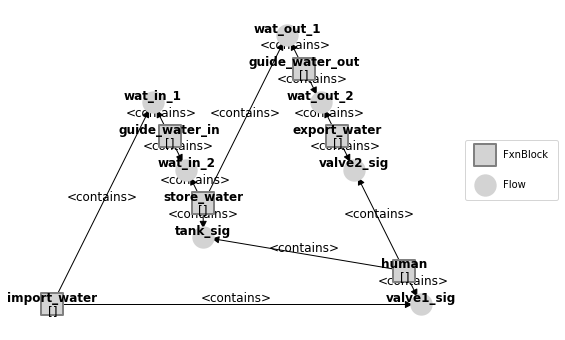

In [4]:

fig = result.graph.draw(figsize=(8,6))

As can be seen, this gives a graphical representation of the functional model with the various flows. Since all of the functions are *grey*, no faults were accidentally introduced in this run.

A model history is additionally returned given our specified tracking options. If none are provided, the `default_track` variable in the `Model` is used (which in this case is set to `all`). It also shows the datatype for each (all arrays). See below:

In [5]:
mdlhist

fxns.import_water.s.amt_open:  array(21)
fxns.import_water.m.faults.stuck: array(21)
fxns.import_water.m.mode:      array(21)
fxns.guide_water_in.m.faults.leak: array(21)
fxns.guide_water_in.m.faults.clogged: array(21)
fxns.guide_water_in.m.mode:    array(21)
fxns.store_water.s.level:      array(21)
fxns.store_water.s.net_flow:   array(21)
fxns.store_water.m.faults.leak: array(21)
fxns.store_water.m.mode:       array(21)
fxns.guide_water_out.m.faults.leak: array(21)
fxns.guide_water_out.m.faults.clogged: array(21)
fxns.guide_water_out.m.mode:   array(21)
fxns.export_water.s.amt_open:  array(21)
fxns.export_water.m.faults.stuck: array(21)
fxns.export_water.m.mode:      array(21)
fxns.human.a.actions           array(21)
fxns.human.a.actions.look.m.mode: array(21)
fxns.human.a.actions           array(21)
fxns.human.a.actions           array(21)
fxns.human.a.actions           array(21)
fxns.human.a.actions.detect.m.mode: array(21)
fxns.human.a.actions           array(21)
fxns.human.a.actio

We can also look at the history of each function to check if it nominal or faulty. First checking to see if the the `store_water` function is nominal and then verifying that it is at the constant level throughout these time steps

In [6]:
mdlhist.fxns.store_water.m.mode

array(['nominal', 'nominal', 'nominal', 'nominal', 'nominal', 'nominal',
       'nominal', 'nominal', 'nominal', 'nominal', 'nominal', 'nominal',
       'nominal', 'nominal', 'nominal', 'nominal', 'nominal', 'nominal',
       'nominal', 'nominal', 'nominal'], dtype='<U7')

In [7]:
mdlhist.fxns.store_water.s.level

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10.])

We can further look at the states of the model using `an.plot.hist`. Input the specific graphs you want to see, here showing that water_in == water_out, that the store water value is constant, and that there is no signal from the tank to indicate anything is wrong. Note that units are not included.

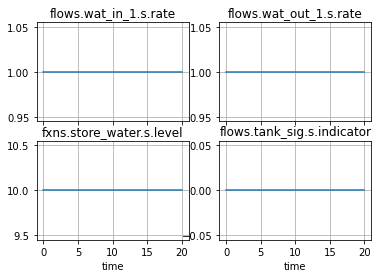

In [8]:
fig, ax =an.plot.hist(mdlhist ,'flows.wat_in_1.s.rate', 
                               'flows.wat_out_1.s.rate', 
                               'fxns.store_water.s.level', 
                               'flows.tank_sig.s.indicator')

### History
If we want to see this data in tabular form, we can use `mdlhist.as_table()`. This also includes indexing on the table to only see parts of it.

This table is a pandas dataframe. We can save this dataframe to a .csv using `nominal_histtable.to_csv("filename.csv")`

In [9]:
nominal_histtable = mdlhist.as_table()
nominal_histtable[:10] #only displaying 10 

,fxns.import_water.s.amt_open,fxns.import_water.m.faults.stuck,fxns.import_water.m.mode,fxns.guide_water_in.m.faults.leak,fxns.guide_water_in.m.faults.clogged,fxns.guide_water_in.m.mode,fxns.store_water.s.level,fxns.store_water.s.net_flow,fxns.store_water.m.faults.leak,fxns.store_water.m.mode,...,flows.wat_out_1.s.rate,flows.wat_out_2.s.effort,flows.wat_out_2.s.rate,flows.valve1_sig.s.indicator,flows.valve1_sig.s.action,flows.tank_sig.s.indicator,flows.tank_sig.s.action,flows.valve2_sig.s.indicator,flows.valve2_sig.s.action,time
0,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,0.0
1,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,1.0
2,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,2.0
3,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,3.0
4,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,4.0
5,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,5.0
6,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,6.0
7,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,7.0
8,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,8.0
9,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,9.0


### What happens under component faults?


Here we model a leak of the tank. To compensate for this leak, the operator opens the first valve to a higher setting, maintaining the level of the tank. This is done with `propagate.one_fault`, which tells the model that a fault has occured and when it did occure. Note that this fault was part of the history earlier as `fxns.store_water.m.faults.leak`. 

Here, the store_water level drops until the indicator turns on and allows for the system to compensate to keep the tank from fully emptying. Blue represents nominal state and red is the fault scenario.

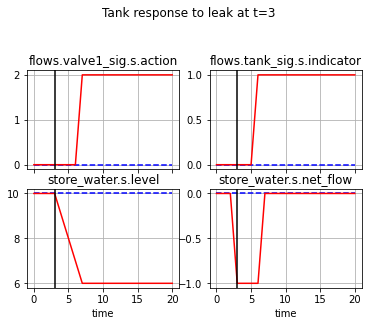

In [10]:
resgraph, mdlhist = propagate.one_fault(mdl,'store_water','leak', time=3,track='all',desired_result=['graph','endclass','endfaults'])

fig, ax = an.plot.hist(mdlhist,'flows.valve1_sig.s.action',
                       'flows.tank_sig.s.indicator',
                       'store_water.s.level', 
                       'store_water.s.net_flow',title="Tank response to leak at t=3",time_slice=3,legend_loc=False, title_padding=0.1)


We can also view the model again with highlighed areas to show the faults visually. The `draw_from` function requires both the time step you're call (here, it's at `10` since that is after the fault occured). For more uses of this function, including animations, see `Pump_Example_Notebook.ipynb` in the pump example folder.

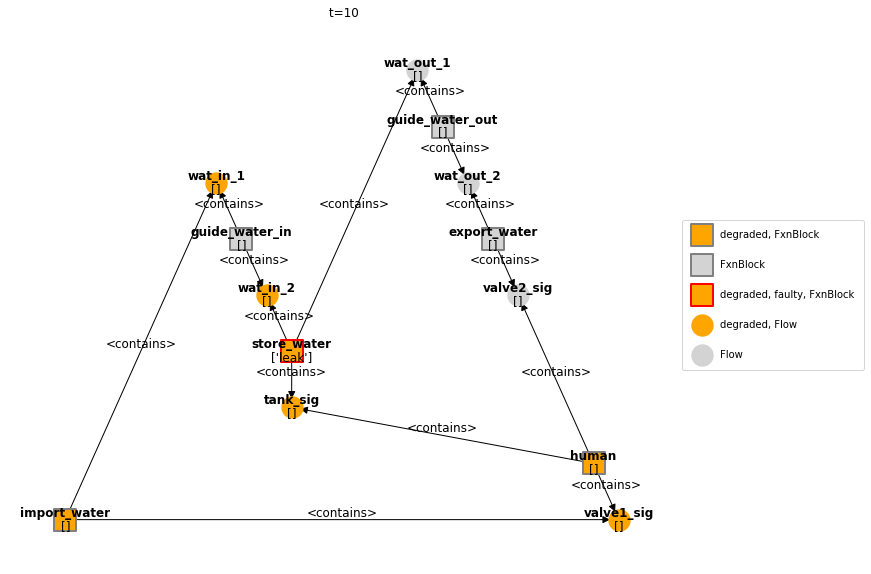

In [11]:
mg = ModelGraph(mdl)
fig, ax = mg.draw_from(10,mdlhist)

Now mdlhist has double the number of entries--those corresponding to the nominal and faulty scenarios.

In [12]:

fault_histtable = mdlhist.as_table()
fault_histtable


,nominal.fxns.import_water.s.amt_open,nominal.fxns.import_water.m.faults.stuck,nominal.fxns.import_water.m.mode,nominal.fxns.guide_water_in.m.faults.leak,nominal.fxns.guide_water_in.m.faults.clogged,nominal.fxns.guide_water_in.m.mode,nominal.fxns.store_water.s.level,nominal.fxns.store_water.s.net_flow,nominal.fxns.store_water.m.faults.leak,nominal.fxns.store_water.m.mode,...,faulty.flows.wat_out_1.s.rate,faulty.flows.wat_out_2.s.effort,faulty.flows.wat_out_2.s.rate,faulty.flows.valve1_sig.s.indicator,faulty.flows.valve1_sig.s.action,faulty.flows.tank_sig.s.indicator,faulty.flows.tank_sig.s.action,faulty.flows.valve2_sig.s.indicator,faulty.flows.valve2_sig.s.action,faulty.time
0,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,0.0
1,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,1.0
2,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,2.0
3,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,3.0
4,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,4.0
5,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,0,0,1,0,5.0
6,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,1,0,1,0,1,0,6.0
7,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,2,2,1,0,1,0,7.0
8,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,2,2,1,0,1,0,8.0
9,1,False,nominal,False,False,nominal,10.0,0.0,False,nominal,...,1.0,1.0,1.0,2,2,1,0,1,0,9.0


Note how, compared to the previos history table, this one does not include all values rather only the component that was affected (IE the store water function. We can further us `History.get_degraded_hist` compares the results over time so we can see what functions and flows were degraded over time. We can then use the summary to view a list of the functions and flows that were impacted over time.

We can the the view it as a table again, but compared to the previous it only shows if the fault occurs.

In [13]:
deghist = mdlhist.get_degraded_hist(*mdl.fxns, *mdl.flows)
deghist.as_table()

,import_water,guide_water_in,store_water,guide_water_out,export_water,human,wat_in_1,wat_in_2,wat_out_1,wat_out_2,valve1_sig,tank_sig,valve2_sig,total,time
0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0.0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1.0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,2.0
3,1,1,0,1,1,1,1,1,1,1,1,1,1,1,3.0
4,1,1,0,1,1,1,1,1,1,1,1,1,1,1,4.0
5,1,1,0,1,1,1,1,1,1,1,1,1,1,1,5.0
6,1,1,0,1,1,1,1,1,1,1,1,0,1,2,6.0
7,0,1,0,1,1,0,0,0,1,1,0,0,1,7,7.0
8,0,1,0,1,1,1,0,0,1,1,0,0,1,6,8.0
9,0,1,0,1,1,1,0,0,1,1,0,0,1,6,9.0


### What about human-induced faults?

Here we evaluate what happens if the operator thinks they see a low or high indicator and takes those given actions.

Note that in these cases, because of the indicator/procedures, the operators are able to correct for the fault.

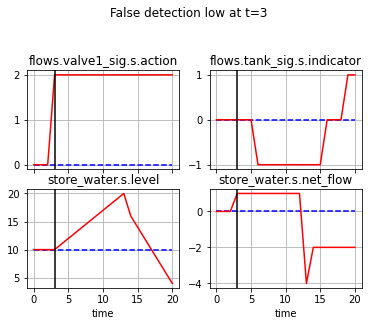

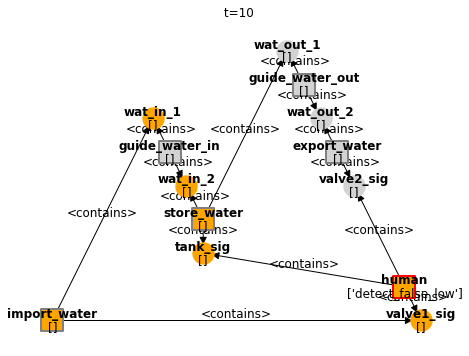

In [14]:
resgraph, mdlhist = propagate.one_fault(mdl,'human','detect_false_low', time=3, track='all',desired_result=['graph','endclass','endfaults'])

#fig, ax= an.plot.mdlhists(mdlhist, title='FalseDetection_low', time_slice=[3], fxnflowvals={'Store_Water':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend_loc=False)
#fig = an.graph.show(resgraph,faultscen='FalseDetection_low', time=3)
fig, ax = an.plot.hist(mdlhist,'flows.valve1_sig.s.action',
                       'flows.tank_sig.s.indicator',
                       'store_water.s.level', 
                       'store_water.s.net_flow',title="False detection low at t=3",time_slice=3,legend_loc=False, title_padding=0.1)

mg = ModelGraph(mdl)
fig, ax = mg.draw_from(10, mdlhist, figsize=(8,6), withlegend=False) #set size and remove legend for legibility.

In [15]:
deghist = mdlhist.get_degraded_hist(*mdl.fxns, *mdl.flows)
deghist.as_table()

,import_water,guide_water_in,store_water,guide_water_out,export_water,human,wat_in_1,wat_in_2,wat_out_1,wat_out_2,valve1_sig,tank_sig,valve2_sig,total,time
0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0.0
1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1.0
2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,2.0
3,0,1,0,1,1,0,0,0,1,1,0,1,1,6,3.0
4,0,1,0,1,1,0,0,0,1,1,0,1,1,6,4.0
5,0,1,0,1,1,0,0,0,1,1,0,1,1,6,5.0
6,0,1,0,1,1,0,0,0,1,1,0,0,1,7,6.0
7,0,1,0,1,1,0,0,0,1,1,0,0,1,7,7.0
8,0,1,0,1,1,0,0,0,1,1,0,0,1,7,8.0
9,0,1,0,1,1,0,0,0,1,1,0,0,1,7,9.0


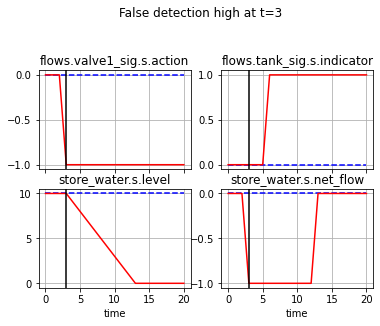

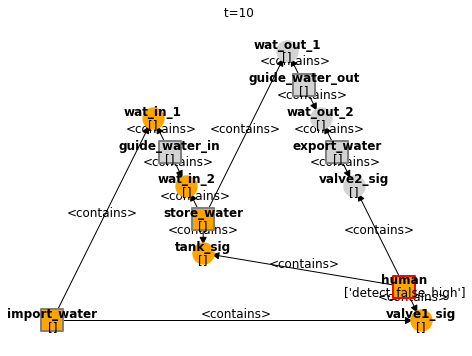

In [16]:
resgraph, mdlhist = propagate.one_fault(mdl,'human','detect_false_high', time=3, track='all',desired_result=['graph','endclass','endfaults'])

#fig, ax= an.plot.mdlhists(mdlhist, title='FalseDetection_low', time_slice=[3], fxnflowvals={'Store_Water':['level', 'net_flow'], 'Tank_Sig':['indicator'], 'Valve1_Sig':['action']}, legend_loc=False)
#fig = an.graph.show(resgraph,faultscen='FalseDetection_low', time=3)
fig, ax = an.plot.hist(mdlhist,'flows.valve1_sig.s.action',
                       'flows.tank_sig.s.indicator',
                       'store_water.s.level', 
                       'store_water.s.net_flow',title="False detection high at t=3",time_slice=3,legend_loc=False, title_padding=0.1)

mg = ModelGraph(mdl)
fig, ax = mg.draw_from(10, mdlhist, figsize=(8,6), withlegend=False) #set size and remove legend for legibility.

### Evaluating Joint Component-Human fault modes 

To understand where the risks of failure are, we need to find the scenarios, that, with the modelled human controls, still lead to failures. To assess this, we develop a sample approach.

In [17]:
#app_full = SampleApproach(mdl)
#endclasses, mdlhists = fp.run_approach(mdl, app_full)

Here we consider all single and joint-fault scenarios in the set of simulations to see which ones lead to failure:

In [18]:
app = SampleApproach(mdl, faults='all',jointfaults={'faults':2})
endclasses, mdlhists=propagate.approach(mdl, app, track="all")
#app_joint_faults = SampleApproach(mdl, faults='all', jointfaults={'faults': 2})
#endclasses, mdlhists = propagate.approach(mdl, app_joint_faults)

SCENARIOS COMPLETE:   0%|          | 0/92 [00:00<?, ?it/s]

SCENARIOS COMPLETE:   7%|▋         | 6/92 [00:00<00:01, 59.84it/s]

SCENARIOS COMPLETE:  14%|█▍        | 13/92 [00:00<00:01, 65.71it/s]

SCENARIOS COMPLETE:  22%|██▏       | 20/92 [00:00<00:01, 63.08it/s]

SCENARIOS COMPLETE:  29%|██▉       | 27/92 [00:00<00:01, 64.03it/s]

SCENARIOS COMPLETE:  37%|███▋      | 34/92 [00:00<00:00, 66.03it/s]

SCENARIOS COMPLETE:  45%|████▍     | 41/92 [00:00<00:00, 67.27it/s]

SCENARIOS COMPLETE:  52%|█████▏    | 48/92 [00:00<00:00, 68.09it/s]

SCENARIOS COMPLETE:  60%|█████▉    | 55/92 [00:00<00:00, 68.62it/s]

SCENARIOS COMPLETE:  67%|██████▋   | 62/92 [00:00<00:00, 68.98it/s]

SCENARIOS COMPLETE:  75%|███████▌  | 69/92 [00:01<00:00, 69.24it/s]

SCENARIOS COMPLETE:  83%|████████▎ | 76/92 [00:01<00:00, 69.41it/s]

SCENARIOS COMPLETE:  90%|█████████ | 83/92 [00:01<00:00, 66.38it/s]

SCENARIOS COMPLETE:  98%|█████████▊| 90/92 [00:01<00:00, 67.38it/s]

SCENARIOS COMPLETE: 100%|██████████| 92/92 [00:01<00:00, 67.02it/s]

In [19]:
fmea_tab = an.tabulate.result_summary_fmea(endclasses, mdlhist) #note, this is currently behaving odd even without the joint fault cases
fmea_tab

,degraded,faulty,rate,cost,expected cost
nominal,[],[],1.0,0.0,0.0
faulty,[],[],NaN,NaN,NaN
guide_water_out_clogged_ human_detect_not_detected_t0p0,NaN,NaN,0.000001,1000000.0,105353.394172
guide_water_out_leak_ human_turn_wrong_valve_t0p0,NaN,NaN,0.000001,1000000.0,65578.190231
export_water_stuck_t0p0,NaN,NaN,0.000002,0.0,0.0
...,...,...,...,...,...
store_water_leak_ human_look_not_visible_t0p0,NaN,NaN,0.0,1000000.0,25586.361139
guide_water_out_clogged_ human_detect_false_low_t0p0,NaN,NaN,0.000001,1000000.0,65578.190231
store_water_leak_ export_water_stuck_t0p0,NaN,NaN,0.0,0.0,0.0
human_reach_unable_t0p0,NaN,NaN,0.5,0.0,0.0


Next, we can filter out non-failures and sort by the failures with the highest expected cost (though rate would give the same results here)

In [20]:
failure_tab = fmea_tab[fmea_tab['cost'] > 1]
failure_tab.sort_values('expected cost', ascending = False)

,degraded,faulty,rate,cost,expected cost
human_detect_false_high_t0p0,NaN,NaN,0.5,1000000.0,50000000000.0
human_detect_false_low_t0p0,NaN,NaN,0.5,1000000.0,50000000000.0
guide_water_in_clogged_t0p0,NaN,NaN,0.000002,1000000.0,166666.666667
guide_water_out_leak_t0p0,NaN,NaN,0.000002,1000000.0,166666.666667
guide_water_out_clogged_ human_detect_not_detected_t0p0,NaN,NaN,0.000001,1000000.0,105353.394172
guide_water_out_leak_ human_grasp_cannot_t0p0,NaN,NaN,0.000001,1000000.0,105353.394172
guide_water_out_leak_ human_detect_not_detected_t0p0,NaN,NaN,0.000001,1000000.0,105353.394172
guide_water_out_clogged_ human_turn_cannot_t0p0,NaN,NaN,0.000001,1000000.0,105353.394172
guide_water_out_clogged_ human_grasp_cannot_t0p0,NaN,NaN,0.000001,1000000.0,105353.394172
guide_water_in_leak_ human_turn_cannot_t0p0,NaN,NaN,0.000001,1000000.0,105353.394172


One of the top modes is a joint human-component failure mode. Let's see what happens in this case:

In [21]:
mdlhists.keys()

dict_keys(['import_water_stuck_t0p0.fxns.import_water.s.amt_open', 'import_water_stuck_t0p0.fxns.import_water.m.faults.stuck', 'import_water_stuck_t0p0.fxns.import_water.m.mode', 'import_water_stuck_t0p0.fxns.guide_water_in.m.faults.leak', 'import_water_stuck_t0p0.fxns.guide_water_in.m.faults.clogged', 'import_water_stuck_t0p0.fxns.guide_water_in.m.mode', 'import_water_stuck_t0p0.fxns.store_water.s.level', 'import_water_stuck_t0p0.fxns.store_water.s.net_flow', 'import_water_stuck_t0p0.fxns.store_water.m.faults.leak', 'import_water_stuck_t0p0.fxns.store_water.m.mode', 'import_water_stuck_t0p0.fxns.guide_water_out.m.faults.leak', 'import_water_stuck_t0p0.fxns.guide_water_out.m.faults.clogged', 'import_water_stuck_t0p0.fxns.guide_water_out.m.mode', 'import_water_stuck_t0p0.fxns.export_water.s.amt_open', 'import_water_stuck_t0p0.fxns.export_water.m.faults.stuck', 'import_water_stuck_t0p0.fxns.export_water.m.mode', 'import_water_stuck_t0p0.fxns.human.a.actions.look.m.faults.not_visible', 'i

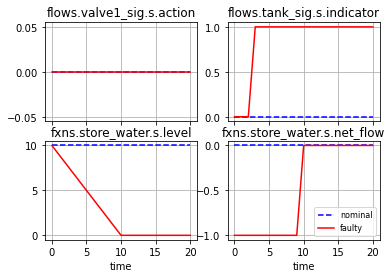

In [22]:
from fmdtools.analyze.result import History
scenhists = History({'nominal':mdlhists.nominal, 
            'faulty':mdlhists.get('guide_water_in_leak_ human_detect_not_detected_t0p0')})
#scenhists.flatten()
fig, axs = an.plot.hist(scenhists,'flows.valve1_sig.s.action',
                       'flows.tank_sig.s.indicator',
                       'fxns.store_water.s.level', 
                       'fxns.store_water.s.net_flow')


In this case, there is a leak, but the operator cannot turn the valve, resulting in the tank filling too high, which is a failure.

To consider the leak again, we can see what happens when the leak is not detected:

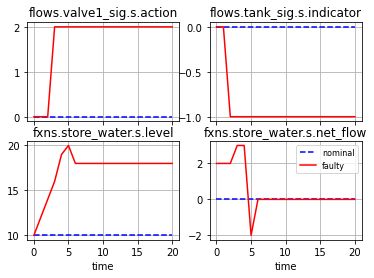

In [23]:
scenhists =History({'nominal':mdlhists.nominal, 'faulty':mdlhists.get('guide_water_out_leak_ human_detect_false_low_t0p0')})
scenhists.flatten()
fig, axs = an.plot.hist(scenhists,'flows.valve1_sig.s.action',
                       'flows.tank_sig.s.indicator',
                       'fxns.store_water.s.level', 
                       'fxns.store_water.s.net_flow')

In this case, there is a leak, but it is not caugh, resulting in a failure again.

### Testing different reaction times

The model set up in `tank_model` is parameterized by the reaction time of the operator. As a result, we can assess how long or short reaction times affect the given scenarios.

In [24]:
mdl_long_reaction_time = Tank(p={'reacttime':10, "store_tstep":1.0}) #also needs reconfiguring

In this case, we will show the affect of reaction time on the operator's ability to catch a leak.

(<Figure size 864x720 with 1 Axes>, <Axes: >)

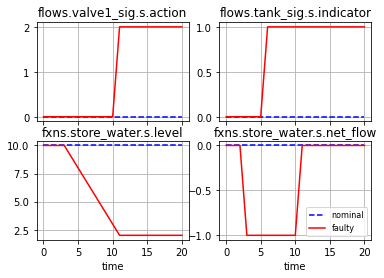

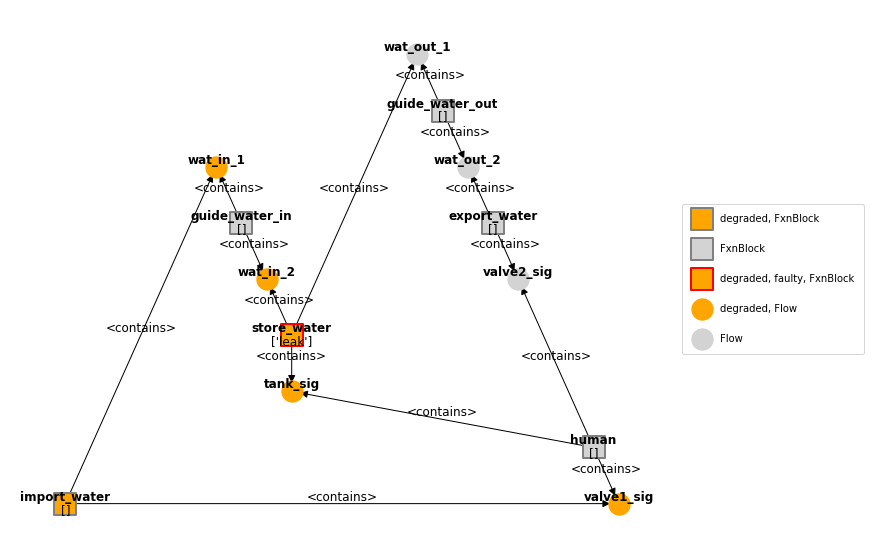

In [25]:
result, mdlhist = propagate.one_fault(mdl_long_reaction_time,'store_water','leak', time=3,track="all", desired_result='graph')

fig, axs = an.plot.hist(mdlhist,'flows.valve1_sig.s.action',
                       'flows.tank_sig.s.indicator',
                       'fxns.store_water.s.level', 
                       'fxns.store_water.s.net_flow')

result.graph.draw()


As shown, the operator does not respond in time, resulting in the tank draining all the way, a failure state. We can further use the `propagate.approach` function to compare the number of scenarios caught in this system compared with the other.